# Démonstration de l'algorithme BPE (Byte Pair Encoding)

Ce notebook démontre pas à pas l'algorithme de tokenisation BPE (Byte Pair Encoding) utilisé dans de nombreux modèles de langage modernes comme GPT, BERT, et autres.

Nous allons explorer :
1. Comment le texte est représenté en Unicode
2. L'implémentation de l'algorithme BPE
3. Comment encoder et décoder du texte avec notre tokenizer BPE

## Introduction

Le BPE est une méthode de compression de données qui remplace itérativement les paires de caractères ou de tokens les plus fréquentes par un nouveau token. Dans le contexte du NLP, cela permet de créer un vocabulaire de sous-mots qui équilibre la taille du vocabulaire et la capacité à représenter des mots rares ou inconnus.

In [1]:
# Import des bibliothèques nécessaires
import re
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configuration de l'affichage
plt.style.use('ggplot')
sns.set(font_scale=1.2)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

## 1. Représentation Unicode du texte

Avant de plonger dans le BPE, examinons comment le texte est représenté en informatique. Chaque caractère a un code Unicode unique.

In [21]:
def show_unicode_representation(text):
    """Affiche la représentation Unicode de chaque caractère d'un texte."""
    unicode_repr = [(char, ord(char), hex(ord(char))) for char in text]
    df = pd.DataFrame(unicode_repr, columns=['Caractère', 'Code Unicode (décimal)', 'Code Unicode (hex)'])
    return df

# Exemple de texte à utiliser pour notre démonstration
sample_text = "Unicode is what allows me to say hello in over 100 languages—እው ሰላም ነው (Amharic), 你好 (Chinese), γεια (Greek), שלום (Hebrew), नमस्ते (Hindi), こんにちは (Japanese), سلام (Persian), cześć (Polish), Привет (Russian)"
print(f"Texte d'exemple: {sample_text}")
df = show_unicode_representation(sample_text)
# save the dataframe to a csv file
df.to_json('unicode_representation.json', orient='records', lines=True)
df


Texte d'exemple: Unicode is what allows me to say hello in over 100 languages—እው ሰላም ነው (Amharic), 你好 (Chinese), γεια (Greek), שלום (Hebrew), नमस्ते (Hindi), こんにちは (Japanese), سلام (Persian), cześć (Polish), Привет (Russian)


,Caractère,Code Unicode (décimal),Code Unicode (hex)
0,U,85,0x55
1,n,110,0x6e
2,i,105,0x69
3,c,99,0x63
4,o,111,0x6f
...,...,...,...
202,s,115,0x73
203,i,105,0x69
204,a,97,0x61
205,n,110,0x6e


In [22]:
# get a row corresponding to the character "س"
df[df['Caractère'] == 'س']

,Caractère,Code Unicode (décimal),Code Unicode (hex)
159,س,1587,0x633


In [24]:
print(list(map(int, sample_text.encode('utf-8'))))
print(f"nombre de caractères: {len(sample_text)}")
print(f"nombre d'octets: {len(sample_text.encode('utf-8'))}")

[85, 110, 105, 99, 111, 100, 101, 32, 105, 115, 32, 119, 104, 97, 116, 32, 97, 108, 108, 111, 119, 115, 32, 109, 101, 32, 116, 111, 32, 115, 97, 121, 32, 104, 101, 108, 108, 111, 32, 105, 110, 32, 111, 118, 101, 114, 32, 49, 48, 48, 32, 108, 97, 110, 103, 117, 97, 103, 101, 115, 226, 128, 148, 225, 138, 165, 225, 139, 141, 32, 225, 136, 176, 225, 136, 139, 225, 136, 157, 32, 225, 138, 144, 225, 139, 141, 32, 40, 65, 109, 104, 97, 114, 105, 99, 41, 44, 32, 228, 189, 160, 229, 165, 189, 32, 40, 67, 104, 105, 110, 101, 115, 101, 41, 44, 32, 206, 179, 206, 181, 206, 185, 206, 177, 32, 40, 71, 114, 101, 101, 107, 41, 44, 32, 215, 169, 215, 156, 215, 149, 215, 157, 32, 40, 72, 101, 98, 114, 101, 119, 41, 44, 32, 224, 164, 168, 224, 164, 174, 224, 164, 184, 224, 165, 141, 224, 164, 164, 224, 165, 135, 32, 40, 72, 105, 110, 100, 105, 41, 44, 32, 227, 129, 147, 227, 130, 147, 227, 129, 171, 227, 129, 161, 227, 129, 175, 32, 40, 74, 97, 112, 97, 110, 101, 115, 101, 41, 44, 32, 216, 179, 217, 132

## 2. Implémentation de l'algorithme BPE

Le BPE fonctionne selon les étapes suivantes :

1. Commencer avec un vocabulaire composé uniquement des caractères uniques du corpus
2. Tokeniser le corpus en utilisant le vocabulaire actuel
3. Identifier la paire de tokens adjacents la plus fréquente
4. Ajouter la fusion de cette paire au vocabulaire
5. Répéter les étapes 2-4 jusqu'à atteindre la taille de vocabulaire souhaitée ou un nombre d'itérations défini

Nous allons implémenter cette logique étape par étape.

In [5]:
def get_stats(vocab, tokens):
    """Calcule la fréquence de chaque paire de tokens adjacents."""
    pairs = defaultdict(int)
    for word, freq in tokens.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, tokens_dict):
    """Fusionne une paire de tokens dans tous les mots du corpus."""
    new_token = ''.join(pair)
    bigram = re.escape(' '.join(pair))
    pattern = re.compile(f'(?<![\S]){bigram}(?![\S])')
    
    new_tokens = {}
    for word, freq in tokens_dict.items():
        new_word = pattern.sub(new_token, word)
        new_tokens[new_word] = freq
    
    return new_tokens

def apply_bpe(corpus, num_merges):
    """Applique l'algorithme BPE sur un corpus."""
    # Préparation initiale : tokenisation par caractère
    tokens = defaultdict(int)
    for text in corpus:
        # Ajout d'un symbole spécial de fin de mot
        word = ' '.join(list(text)) + ' </w>'
        tokens[word] += 1
    
    # Vocabulaire initial (tous les caractères uniques)
    vocab = set()
    for word in tokens.keys():
        vocab.update(word.split())
    
    # Stockage de l'historique des fusions pour visualisation
    merge_history = []
    vocab_growth = [(0, len(vocab))]
    
    # Exécution des fusions BPE
    for i in range(num_merges):
        # Trouver la paire la plus fréquente
        pairs = get_stats(vocab, tokens)
        if not pairs:
            break
            
        best_pair = max(pairs, key=pairs.get)
        new_token = ''.join(best_pair)
        
        # Enregistrer cette fusion pour l'historique
        merge_history.append((best_pair, pairs[best_pair], new_token))
        
        # Appliquer la fusion
        tokens = merge_vocab(best_pair, tokens)
        vocab.add(new_token)
        vocab_growth.append((i+1, len(vocab)))
        
        # Afficher la progression
        print(f"Fusion {i+1}: {best_pair[0]} + {best_pair[1]} → {new_token} (Fréquence: {pairs[best_pair]})")
    
    # Construction du vocabulaire final et des règles de fusion
    bpe_vocab = sorted(list(vocab))
    bpe_codes = {pair: idx for idx, pair in enumerate(merge_history)}
    
    return bpe_vocab, bpe_codes, merge_history, vocab_growth, tokens

### Application du BPE sur un corpus d'exemple

Pour démontrer l'algorithme, nous allons utiliser un petit corpus de phrases. Dans un cas réel, le BPE serait entraîné sur des millions de phrases.

In [6]:
# Corpus d'exemple (en français pour suivre les slides)
corpus = "Unicode, formally The Unicode Standard,[note 1] is a text encoding standard maintained by the Unicode Consortium designed to support the use of text in all of the world's writing systems that can be digitized. Version 16.0 of the standard[A] defines 154998 characters and 168 scripts[3] used in various ordinary, literary, academic, and technical contexts. Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes 3790 emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters. Unicode has largely supplanted the previous environment of a myriad of incompatible character sets, each used within different locales and on different computer architectures. Unicode is used to encode the vast majority of text on the Internet, including most web pages, and relevant Unicode support has become a common consideration in contemporary software development. The Unicode character repertoire is synchronized with ISO/IEC 10646, each being code-for-code identical with one another. However, The Unicode Standard is more than just a repertoire within which characters are assigned. To aid developers and designers, the standard also provides charts and reference data, as well as annexes explaining concepts germane to various scripts, providing guidance for their implementation. Topics covered by these annexes include character normalization, character composition and decomposition, collation, and directionality.[5]"

# Préparation du corpus : diviser en mots pour simuler un corpus plus réaliste
words = []
words.extend(re.findall(r"[\w']+|[.,!?;]", corpus))

print(f"Corpus d'exemple de {len(corpus)} caractères et {len(words)} mots.")
print(f"Exemples de mots: {words[:10]}")

# Appliquons l'algorithme BPE avec 25 fusions
num_merges = 25
bpe_vocab, bpe_codes, merge_history, vocab_growth, tokenized_corpus = apply_bpe(words, num_merges)

Corpus d'exemple de 1791 caractères et 303 mots.
Exemples de mots: ['Unicode', ',', 'formally', 'The', 'Unicode', 'Standard', ',', 'note', '1', 'is']
Fusion 1: e + </w> → e</w> (Fréquence: 54)
Fusion 2: s + </w> → s</w> (Fréquence: 40)
Fusion 3: d + </w> → d</w> (Fréquence: 34)
Fusion 4: c + o → co (Fréquence: 32)
Fusion 5: a + r → ar (Fréquence: 31)
Fusion 6: a + n → an (Fréquence: 30)
Fusion 7: t + h → th (Fréquence: 28)
Fusion 8: e + r → er (Fréquence: 28)
Fusion 9: i + n → in (Fréquence: 27)
Fusion 10: , + </w> → ,</w> (Fréquence: 22)
Fusion 11: o + n → on (Fréquence: 22)
Fusion 12: t + </w> → t</w> (Fréquence: 19)
Fusion 13: co + d → cod (Fréquence: 17)
Fusion 14: t + i → ti (Fréquence: 17)
Fusion 15: o + r → or (Fréquence: 16)
Fusion 16: on + </w> → on</w> (Fréquence: 15)
Fusion 17: c + h → ch (Fréquence: 15)
Fusion 18: cod + e</w> → code</w> (Fréquence: 14)
Fusion 19: e + n → en (Fréquence: 14)
Fusion 20: e + d</w> → ed</w> (Fréquence: 14)
Fusion 21: th + e</w> → the</w> (Fréque

### Visualisation de l'évolution du vocabulaire

In [7]:
# Affichage de l'historique des fusions
df_merges = pd.DataFrame(merge_history, columns=['Paire fusionnée', 'Fréquence', 'Nouveau token'])
df_merges.index = df_merges.index + 1  # Commencer l'index à 1
df_merges.index.name = 'Étape'
df_merges

,Paire fusionnée,Fréquence,Nouveau token
Étape,,,
1,"(e, </w>)",54,e</w>
2,"(s, </w>)",40,s</w>
3,"(d, </w>)",34,d</w>
4,"(c, o)",32,co
5,"(a, r)",31,ar
6,"(a, n)",30,an
7,"(t, h)",28,th
8,"(e, r)",28,er
9,"(i, n)",27,in


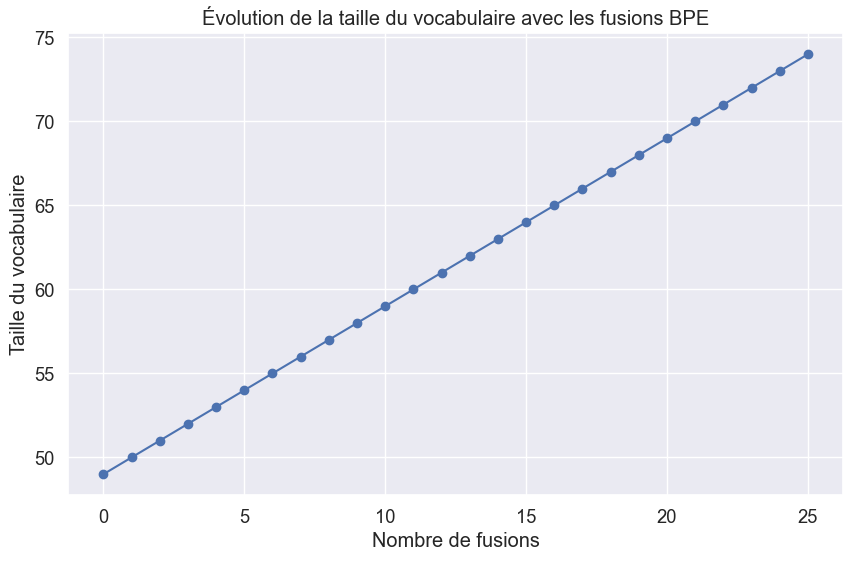

Vocabulaire final (74 tokens):
["'", ',', ',</w>', '.', '.</w>', '0', '1', '3', '4', '5', '6', '7', '8', '9', '</w>', 'A', 'C', 'E', 'H', 'I', 'J', 'M', 'O', 'S', 'T', 'U', 'V', 'a', 'an', 'ar', 'b', 'c', 'ch', 'co', 'cod', 'code</w>', 'd', 'd</w>', 'e', 'e</w>', 'ed</w>', 'en', 'er', 'f', 'g', 'h', 'i', 'in', 'j', 'l', 'm', 'n', 'ni', 'o', 'of', 'on', 'on</w>', 'or', 'p', 'r', 's', 's</w>', 't', 't</w>', 'th', 'the</w>', 'ti', 'u', 'v', 'w', 'x', 'y', 'y</w>', 'z']


In [8]:
# Graphique de l'évolution de la taille du vocabulaire
plt.figure(figsize=(10, 6))
x, y = zip(*vocab_growth)
plt.plot(x, y, marker='o')
plt.title('Évolution de la taille du vocabulaire avec les fusions BPE')
plt.xlabel('Nombre de fusions')
plt.ylabel('Taille du vocabulaire')
plt.grid(True)
plt.show()

# Affichage du vocabulaire final
print(f"Vocabulaire final ({len(bpe_vocab)} tokens):")
print(bpe_vocab)

## 3. Encoder et décoder du texte avec notre tokenizer BPE

Maintenant que nous avons construit notre vocabulaire BPE, nous pouvons l'utiliser pour tokeniser (encoder) et détokeniser (décoder) du texte.

In [9]:
def encode_word(word, bpe_codes, bpe_vocab):
    """Encode un mot en utilisant les règles BPE."""
    # Initialisation : tokenisation par caractère
    word = ' '.join(list(word)) + ' </w>'
    
    # Application des règles de fusion dans l'ordre où elles ont été apprises
    for pairs, idx in sorted(bpe_codes.items(), key=lambda x: x[1]):
        pair_str = pairs[0]
        bigram = re.escape(' '.join(pair_str))
        pattern = re.compile(f'(?<![\S]){bigram}(?![\S])')
        replacement = ''.join(pair_str)
        word = pattern.sub(replacement, word)
    
    # Conversion en IDs de tokens
    tokens = word.split()
    token_ids = [bpe_vocab.index(token) if token in bpe_vocab else bpe_vocab.index('<unk>') for token in tokens]
    
    return tokens, token_ids

def decode_tokens(tokens):
    """Décode une liste de tokens BPE en texte."""
    # Joindre les tokens et remplacer le symbole de fin de mot
    text = ''.join(tokens).replace('</w>', ' ').strip()
    return text

# Encoder une phrase d'exemple
def encode_sentence(sentence, bpe_codes, bpe_vocab):
    """Encode une phrase complète en utilisant BPE."""
    words = re.findall(r"[\w']+|[.,!?;]", sentence)
    encoded_words = [encode_word(word, bpe_codes, bpe_vocab) for word in words]
    all_tokens = [token for word_tokens, _ in encoded_words for token in word_tokens]
    all_ids = [id for _, word_ids in encoded_words for id in word_ids]
    
    return all_tokens, all_ids, encoded_words

In [11]:
# Ajoutons <unk> au vocabulaire pour les tokens inconnus
if '<unk>' not in bpe_vocab:
    bpe_vocab.append('<unk>')

# Phrases d'exemple pour démontrer l'encodage et le décodage
test_sentences = "Unicode was originally designed with the intent of transcending limitations present in all text encodings designed up to that point: each encoding was relied upon for use in its own context, but with no particular expectation of compatibility with any other. Indeed, any two encodings chosen were often totally unworkable when used together, with text encoded in one interpreted as garbage characters by the other. Most encodings had only been designed to facilitate interoperation between a handful of scripts—often primarily between a given script and Latin characters—not between a large number of scripts, and not with all of the scripts supported being treated in a consistent manner."

print(f"\nPhrase d'origine: {test_sentences}")
tokens, token_ids, word_encodings = encode_sentence(test_sentences, bpe_codes, bpe_vocab)

print(f"Tokens BPE: {tokens}")
print(f"IDs des tokens: {token_ids}")

# Affichage détaillé par mot
print("\nEncodage détaillé par mot:")
words = re.findall(r"[\w']+|[.,!?;]", test_sentences)
for i, word in enumerate(words):
    word_tokens, word_ids = word_encodings[i]
    print(f"  '{word}' → {word_tokens} (IDs: {word_ids})")

# Décodage
decoded = decode_tokens(tokens)
print(f"\nTexte décodé: {decoded}")


Phrase d'origine: Unicode was originally designed with the intent of transcending limitations present in all text encodings designed up to that point: each encoding was relied upon for use in its own context, but with no particular expectation of compatibility with any other. Indeed, any two encodings chosen were often totally unworkable when used together, with text encoded in one interpreted as garbage characters by the other. Most encodings had only been designed to facilitate interoperation between a handful of scripts—often primarily between a given script and Latin characters—not between a large number of scripts, and not with all of the scripts supported being treated in a consistent manner.
Tokens BPE: ['U', 'ni', 'code</w>', 'w', 'a', 's</w>', 'or', 'i', 'g', 'in', 'a', 'l', 'l', 'y</w>', 'd', 'e', 's', 'i', 'g', 'n', 'ed</w>', 'w', 'i', 'th', '</w>', 'the</w>', 'in', 't', 'en', 't</w>', 'of', '</w>', 't', 'r', 'an', 's', 'c', 'en', 'd', 'in', 'g', '</w>', 'l', 'i', 'm', 'i',

## 4. Comparaison des différentes méthodes de tokenisation

Pour conclure, comparons notre tokenisation BPE avec d'autres approches comme la tokenisation par mot et par caractère.

In [18]:
def compare_tokenization_methods(sentence):
    """Compare différentes méthodes de tokenisation sur une phrase."""
    # 1. Tokenisation par caractère
    char_tokens = list(sentence)
    char_vocab_size = len(set(char_tokens))
    
    # 2. Tokenisation par mot
    word_tokens = re.findall(r"[\w']+|[.,!?;]", sentence)
    word_vocab_size = len(set(word_tokens))
    
    # 3. Tokenisation BPE (notre implémentation)
    bpe_tokens, _, _ = encode_sentence(sentence, bpe_codes, bpe_vocab)
    bpe_vocab_size = len(bpe_vocab)
    
    # Création d'un DataFrame comparatif
    compare_df = pd.DataFrame({
        'Méthode': ['Caractère', 'Mot', 'BPE'],
        'Nombre de tokens': [len(char_tokens), len(word_tokens), len(bpe_tokens)],
        'Taille du vocabulaire': [char_vocab_size, word_vocab_size, bpe_vocab_size],
        'Tokens': [char_tokens, word_tokens, bpe_tokens]
    })
    
    return compare_df

# Phrase d'exemple pour la comparaison
comparison_sentence ="The philosophy that underpins Unicode seeks to encode the underlying characters—graphemes and grapheme-like units—rather than graphical distinctions considered mere variant glyphs thereof, that are instead best handled by the typeface, through the use of markup, or by some other means. In particularly complex cases, such as the treatment of orthographical variants in Han characters, there is considerable disagreement regarding which differences justify their own encodings, and which are only graphical variants of other characters. At the most abstract level, Unicode assigns a unique number called a code point to each character. Many issues of visual representation—including size, shape, and style—are intended to be up to the discretion of the software actually rendering the text, such as a web browser or word processor. However, partially with the intent of encouraging rapid adoption, the simplicity of this original model has become somewhat more elaborate over time, and various pragmatic concessions have been made over the course of the standard s development. The first 256 code points mirror the ISO/IEC 8859-1 standard, with the intent of trivializing the conversion of text already written in Western European scripts. To preserve the distinctions made by different legacy encodings, therefore allowing for conversion between them and Unicode without any loss of information, many characters nearly identical to others, in both appearance and intended function, were given distinct code points. For example, the Halfwidth and Fullwidth Forms block encompasses a full semantic duplicate of the Latin alphabet, because legacy CJK encodings contained both 'fullwidth' (matching the width of CJK characters) and 'halfwidth' (matching ordinary Latin script) characters. The Unicode Bulldog Award is given to people deemed to be influential in Unicode's development, with recipients including Tatsuo Kobayashi, Thomas Milo, Roozbeh Pournader, Ken Lunde, and Michael Everson.[6]"
comparison_df = compare_tokenization_methods(comparison_sentence)

print(f"Phrase d'exemple: {comparison_sentence}\n")
display(comparison_df)

Phrase d'exemple: The philosophy that underpins Unicode seeks to encode the underlying characters—graphemes and grapheme-like units—rather than graphical distinctions considered mere variant glyphs thereof, that are instead best handled by the typeface, through the use of markup, or by some other means. In particularly complex cases, such as the treatment of orthographical variants in Han characters, there is considerable disagreement regarding which differences justify their own encodings, and which are only graphical variants of other characters. At the most abstract level, Unicode assigns a unique number called a code point to each character. Many issues of visual representation—including size, shape, and style—are intended to be up to the discretion of the software actually rendering the text, such as a web browser or word processor. However, partially with the intent of encouraging rapid adoption, the simplicity of this original model has become somewhat more elaborate over time, 

,Méthode,Nombre de tokens,Taille du vocabulaire,Tokens
0,Caractère,1992,61,"[T, h, e, , p, h, i, l, o, s, o, p, h, y, , ..."
1,Mot,331,202,"[The, philosophy, that, underpins, Unicode, se..."
2,BPE,1468,75,"[T, h, e</w>, p, h, i, l, o, s, o, p, h, y</w>..."


### Analyse de l'efficacité de BPE en fonction du type de texte

Le BPE est particulièrement efficace sur des corpus contenant des motifs répétitifs. Examinons comment le taux de compression varie selon le type de texte.

,Méthode,Longueur moyenne,Longueur minimale,Longueur maximale
0,Caractère,1.000000,1,1
1,Mot,0.849805,0,1
2,BPE,1.412619,0,2


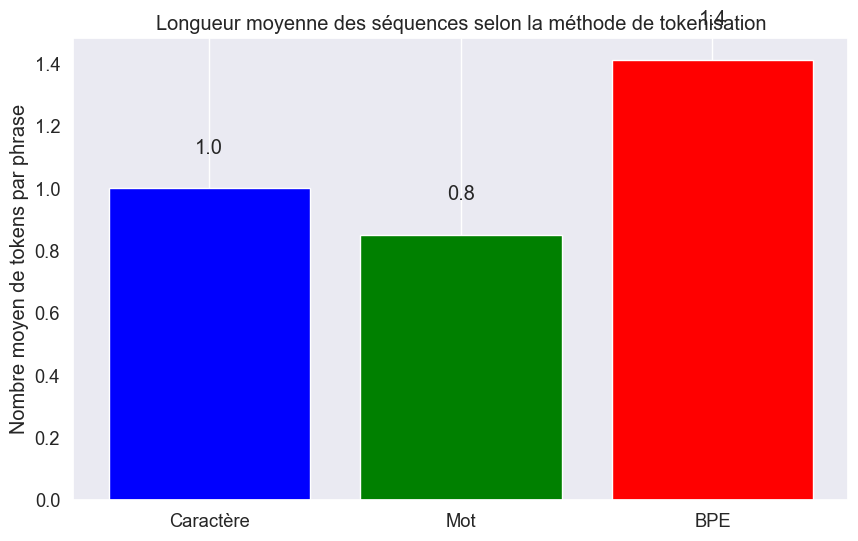

In [19]:
# Fonction pour calculer la taille moyenne des séquences
def analyze_sequence_length(text_corpus, tokenizer_func):
    """Analyse la longueur moyenne des séquences selon la méthode de tokenisation."""
    lengths = []
    for text in text_corpus:
        tokens = tokenizer_func(text)
        lengths.append(len(tokens))
    return {
        "Longueur moyenne": sum(lengths) / len(lengths),
        "Longueur minimale": min(lengths),
        "Longueur maximale": max(lengths)
    }

# Fonctions de tokenisation
def char_tokenize(text):
    return list(text)

def word_tokenize(text):
    return re.findall(r"[\w']+|[.,!?;]", text)

def bpe_tokenize(text):
    tokens, _, _ = encode_sentence(text, bpe_codes, bpe_vocab)
    return tokens

# Analyse comparative sur notre corpus
tokenizers = {
    "Caractère": char_tokenize,
    "Mot": word_tokenize,
    "BPE": bpe_tokenize
}

results = []
for name, tokenizer in tokenizers.items():
    stats = analyze_sequence_length(corpus, tokenizer)
    results.append({"Méthode": name, **stats})

length_df = pd.DataFrame(results)
display(length_df)

# Visualisation comparative
plt.figure(figsize=(10, 6))
bars = plt.bar(length_df["Méthode"], length_df["Longueur moyenne"], color=['blue', 'green', 'red'])

# Ajout des valeurs exactes au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}',
            ha='center', va='bottom')

plt.title("Longueur moyenne des séquences selon la méthode de tokenisation")
plt.ylabel("Nombre moyen de tokens par phrase")
plt.grid(axis='y')
plt.show()

## Conclusion

Dans ce notebook, nous avons exploré l'algorithme BPE (Byte Pair Encoding) de manière détaillée :

1. Nous avons vu comment le texte est représenté en Unicode
2. Nous avons implémenté l'algorithme BPE et visualisé son fonctionnement
3. Nous avons utilisé notre tokenizer BPE pour encoder et décoder du texte
4. Nous avons comparé le BPE avec d'autres méthodes de tokenisation
5. Nous avons analysé la réduction de la taille du corpus grâce au BPE

**Points clés à retenir :**

- Le BPE offre un bon équilibre entre la tokenisation par caractère (vocabulaire petit, séquences longues) et la tokenisation par mot (vocabulaire grand, problème des mots inconnus).
- À mesure que nous augmentons le nombre de fusions BPE, la taille du vocabulaire augmente tandis que la longueur moyenne des séquences diminue.
- Cette compression est particulièrement avantageuse pour les modèles de langage, car elle permet de capturer plus d'information contextuelle avec moins de tokens.
- C'est pourquoi cette approche est utilisée dans de nombreux modèles de langage modernes comme GPT, BERT, et bien d'autres.

En pratique, les implémentations professionnelles du BPE sont plus sophistiquées et optimisées, mais les principes fondamentaux restent les mêmes que ce que nous avons vu ici.